The dataset used is available on Kaggle [at this link](https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data?resource=download).
This dataset comes from a Berkeley Earth study that combines 1.6 billion temperature reports from 16 pre-existing files.

For this project, a subset related to global land average temperature by country will be used.

# Imports

In [203]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from prophet.plot import add_changepoints_to_plot

# EDA and Preprocessing

In [204]:

df = pd.read_csv("/Users/leticiapires/Desktop/dev/ClimateChange/GlobalLandTemperaturesByCountry.csv")

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577462 entries, 0 to 577461
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             577462 non-null  object 
 1   AverageTemperature             544811 non-null  float64
 2   AverageTemperatureUncertainty  545550 non-null  float64
 3   Country                        577462 non-null  object 
dtypes: float64(2), object(2)
memory usage: 17.6+ MB


Each column means:
- **dt**: year, day and month
- **AverageTemperature**: global land average temperature in degrees Celsius
- **AverageTemperatureUncertainty**: uncertainty of the collected temperature values
- **Country**: country

In [206]:
df.head()

dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland

Temperaturas começaram a ser coletadas em 1743.

In [207]:
# Verificar a maior data presente no dataset
df['dt'].max()

'2013-09-01'

Isso significa que temos em torno de 270 anos de valores de temperatura coletados no decorrer do tempo.

Como temos uma grande quantidade de dados pra cada pais, vams=os nos concentrar no Brazil como estudo.

In [208]:
df_brazil = df.query("Country == 'Brazil'")
df_brazil.head()

dt  AverageTemperature  AverageTemperatureUncertainty Country
77110  1832-01-01              24.935                          1.372  Brazil
77111  1832-02-01              24.505                          1.953  Brazil
77112  1832-03-01              24.617                          1.359  Brazil
77113  1832-04-01              23.990                          2.013  Brazil
77114  1832-05-01              23.124                          1.592  Brazil

Series temporais podem ter problemas com dados nulos, entao antes precisamos lidar com eles.

In [209]:
df_brazil.isnull().sum()

dt                                0
AverageTemperature               17
AverageTemperatureUncertainty    17
Country                           0
dtype: int64

In [210]:
df_brazil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2181 entries, 77110 to 79290
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2181 non-null   object 
 1   AverageTemperature             2164 non-null   float64
 2   AverageTemperatureUncertainty  2164 non-null   float64
 3   Country                        2181 non-null   object 
dtypes: float64(2), object(2)
memory usage: 85.2+ KB


Existem muitas formas de lidar com valores nulos, mas para nossa analise decidiu-se efetuar a remocao desses dados, ja que e relativamente pouco.

In [211]:
df_brazil.dropna(inplace=True)

/var/folders/p1/2v8td5_104xbsynzgwgfv23c0000gn/T/ipykernel_39852/822398534.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brazil.dropna(inplace=True)


In [212]:
df_brazil['AverageTemperature'].describe()

count    2164.000000
mean       24.699256
std         0.978787
min        21.797000
25%        24.022500
50%        24.829500
75%        25.449750
max        27.151000
Name: AverageTemperature, dtype: float64

**What can we learn from this describe() output?**

- **count (2164)**: Number of monthly temperature records for Brazil (after dropping nulls). About 180 years of data.
- **mean (~24.7°C)**: The average land temperature in Brazil over the period is around 24.7°C.
- **std (~0.98)**: Relatively low standard deviation — temperatures don’t vary wildly; they stay in a narrow band around the mean.
- **min (21.8°C) / max (27.2°C)**: The range is about 5.4°C. Coldest months are around 22°C and warmest around 27°C (typical for a tropical/subtropical country).
- **quartiles (25%, 50%, 75%)**: Half of the values lie between ~24°C and ~25.5°C; the distribution is fairly symmetric (median 24.8°C is close to the mean).

In short: Brazil’s land temperatures are consistently warm, with moderate seasonal and interannual variation — a good baseline for later comparing trends or extremes.

# Visualizations

<Axes: xlabel='dt', ylabel='AverageTemperature'>

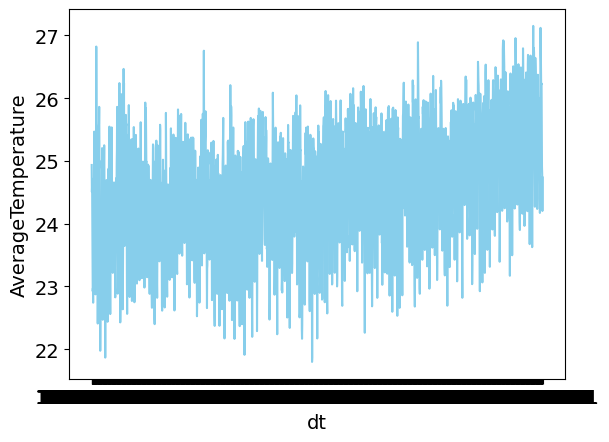

In [213]:
sns.lineplot(x='dt', y='AverageTemperature', data=df_brazil, color='skyblue')

Como podemos ver, no eixo x (data), tivemos um problema. as datas ficaram encavaladas, isso ocorreu porque o seaborn nao entendeu que estamos trabalhando com datas e interpretou a informacao de maneira incorreta. 

In [214]:
df_brazil['dt'] = pd.to_datetime(df_brazil['dt'], format='%Y-%m-%d')

/var/folders/p1/2v8td5_104xbsynzgwgfv23c0000gn/T/ipykernel_39852/664107510.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brazil['dt'] = pd.to_datetime(df_brazil['dt'], format='%Y-%m-%d')


In [215]:
df_brazil.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2164 entries, 77110 to 79289
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   dt                             2164 non-null   datetime64[ns]
 1   AverageTemperature             2164 non-null   float64       
 2   AverageTemperatureUncertainty  2164 non-null   float64       
 3   Country                        2164 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 84.5+ KB


Text(0, 0.5, 'Average Temperature')

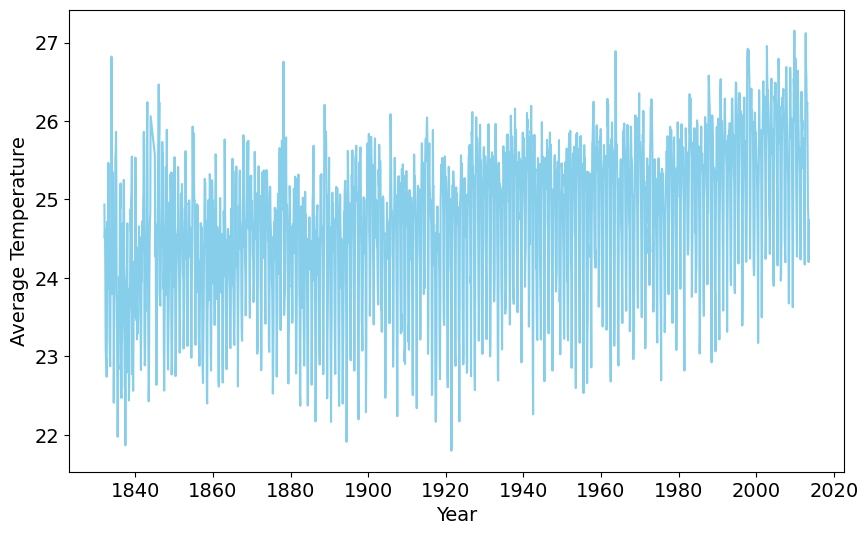

In [216]:
# pra melhorar visualizacao, podemos usar o matplotlib

plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = '14' #ajuste tamanho da fonte
sns.lineplot(x='dt', y='AverageTemperature', data=df_brazil, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

### How to read this graph

- **Range:** Temperatures stay within about 21.5°C to 27.5°C (y-axis), typical for Brazil's climate.
- **Variability:** The line fluctuates a lot from month to month due to seasonal and year-to-year variation.
- **Long-term trend:** The overall level of the series increases from the 1830s to the 2010s, consistent with a warming trend.


In [217]:
# Average temperature by month (1–12) for Brazil
df_brazil['Month'] = df_brazil['dt'].dt.month
temperature = df_brazil.groupby('Month')['AverageTemperature'].mean().to_frame()

/var/folders/p1/2v8td5_104xbsynzgwgfv23c0000gn/T/ipykernel_39852/858706152.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_brazil['Month'] = df_brazil['dt'].dt.month


In [218]:
temperature

AverageTemperature
Month                    
1               25.263696
2               25.258972
3               25.143144
4               24.615188
5               23.971238
6               23.325945
7               23.332978
8               24.263823
9               25.114278
10              25.395045
11              25.452235
12              25.271603

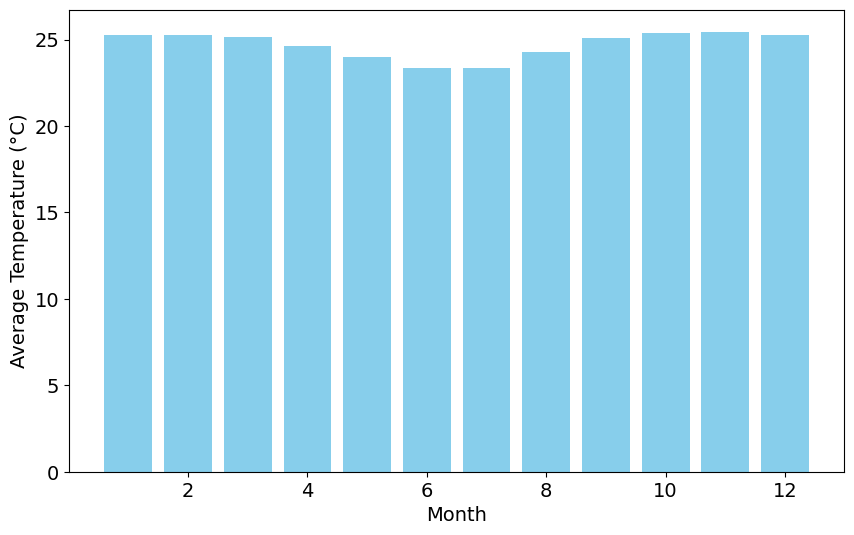

In [219]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = 14
plt.bar(temperature.index, temperature['AverageTemperature'].values, color='skyblue')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.show()

**What can we interpret from this graph?**

This is a **time series** of Brazil's monthly average land temperature from the first records (~1832) until 2013.

- **Oscillating pattern (sawtooth)**: The repeated ups and downs show the **seasonal cycle** — warmer months (e.g. summer) and cooler months (e.g. winter) each year. In Brazil the amplitude is relatively small (about 22°C to 27°C), as expected for a tropical/subtropical country.

- **Long-term trend**: If you look at the overall level of the curve over decades, you can assess whether temperatures are **increasing, stable, or decreasing** over time. Often we see a slight upward drift in recent decades, which can be related to climate change.

- **Variability**: Some periods may look more “noisy” (e.g. more spikes or dips) due to natural variability, measurement uncertainty, or events like El Niño/La Niña.

- **Next steps**: To see the long-term trend more clearly, you can add a **rolling mean** (e.g. 12-month or 120-month) or **annual averages** and plot them on the same figure, so seasonality is smoothed and the trend stands out.

In [220]:
# df_brazil['Month'] = pd.DatetimeIndex(df_brazil['dt']).month

In [221]:
# remover coluna país que não é necessária agora
df_brazil = df_brazil.drop(columns=['Country'])

In [222]:
# temperature = df_brazil.groupby(['Month']).mean()

In [223]:
temperature

AverageTemperature
Month                    
1               25.263696
2               25.258972
3               25.143144
4               24.615188
5               23.971238
6               23.325945
7               23.332978
8               24.263823
9               25.114278
10              25.395045
11              25.452235
12              25.271603

### Monthly pattern and moving average

**Monthly bar chart**: Variation is relatively small — expected for Brazil — but temperatures are **lower in the middle of the year** (around June–August). For stronger seasonal contrast, try a country at higher latitude (e.g. Canada or Russia).

Besides monthly averages, a common way to visualize the series is the **moving average**.

**Moving average**: At each date you take the mean of the **last N values** (e.g. last 12 months), then move the window forward and repeat.

- *Example (12-month)*: Jan 2010 → mean from Feb 2009 to Jan 2010; Feb 2010 → mean from Mar 2009 to Feb 2010; and so on.
- On the **temperature plot**: the raw series goes up and down every month (seasonality); a 12- or 30-month moving average **smooths** those swings and makes the **long-term trend** easier to see.

In [224]:
# 30, calcular a media movel de 30 meses
df_brazil['rolling_average'] = df_brazil['AverageTemperature'].rolling(30).mean()

In [225]:
df_brazil

dt  AverageTemperature  AverageTemperatureUncertainty  Month  \
77110 1832-01-01              24.935                          1.372      1   
77111 1832-02-01              24.505                          1.953      2   
77112 1832-03-01              24.617                          1.359      3   
77113 1832-04-01              23.990                          2.013      4   
77114 1832-05-01              23.124                          1.592      5   
...          ...                 ...                            ...    ...   
79285 2013-04-01              25.464                          0.253      4   
79286 2013-05-01              24.906                          0.236      5   
79287 2013-06-01              24.788                          0.251      6   
79288 2013-07-01              24.202                          0.201      7   
79289 2013-08-01              24.736                          0.247      8   

       rolling_average  
77110              NaN  
77111              NaN  
77112              NaN  
77113              NaN  
77114              NaN  
...                ...  
79285        25.672100  
79286        25.628300  
79287        25.586633  
79288        25.538800  
79289        25.508033  

[2164 rows x 5 columns]

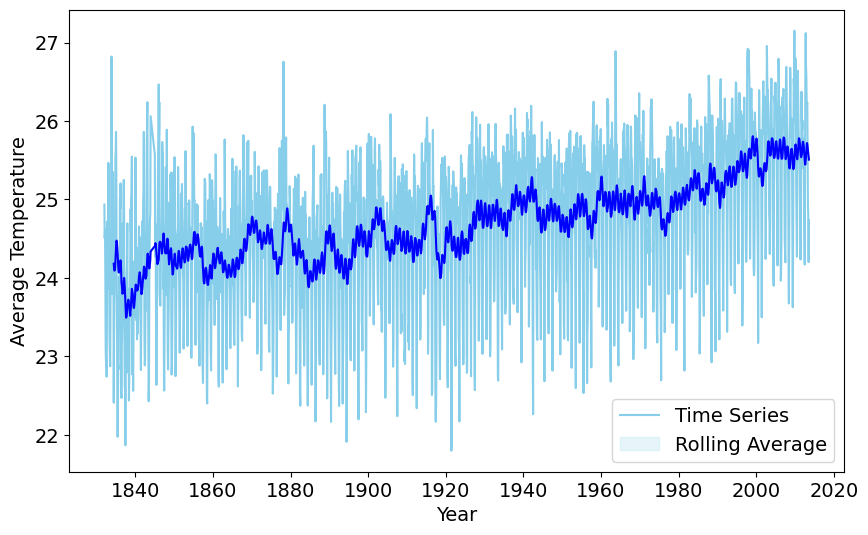

In [226]:
plt.figure(figsize=(10, 6))
plt.rcParams['font.size'] = '14'

sns.lineplot(x='dt', y='AverageTemperature', data=df_brazil, color='skyblue')
plt.xlabel('Year')
plt.ylabel('Average Temperature')

# gerar gráfico da media movel de 30 meses
sns.lineplot(x='dt', y='rolling_average', data=df_brazil, color='blue')
plt.legend(['Time Series', 'Rolling Average'])


Comparing the beginning of the series in the 1800s with the end of the 2000s–2010s, we observe a clear rise in the mean level of the temperature series. While short-term variability remains present throughout the entire period, the baseline around which temperatures fluctuate gradually shifts upward over time. This pattern indicates a persistent warming trend, rather than isolated or temporary spikes.

Overall, the chart shows that temperature variability has always existed, and short-term ups and downs continue to occur due to seasonal and monthly effects. However, what changes over time is the average level of the series. In time-series terms, the data exhibit high short-term variability but a clear positive long-term trend, highlighting a sustained increase in average temperatures.

# Trabalhando com Prophet

A biblioteca foi desenvolvida por Sean J. Taylorr e Ben Letham internamente na empresa Facebook. O lançamento ao público ocorreu em 2017 como um software open source e no artigo Forescasting Scale de Taylor e Letham em 2018.

O Prophet foi desenvolvido com objetivo de superar alguns problemas frequentemente encontrados em outras ferramentas disponíveis para previsão de séries temporais. 

Prophet projetado pra lidar de maneira otimizada com tarefas de previsão com essas caracteristicas: 

- Dados ausentes ou valores discrepantes
- Fortes efeitos de sazonalidade ocorrendo diariamente, semanalmente ou anualmente
- Dados obtidos em períodos horários, diários, semanais com pelo menos um ano inteiro de histórico
- Feriados e outros eventos especiais que não seguem necessariamente padrões de sazonalidade e ocorrem irregularmente
- Mudanças significativas de tendencia.



É um modelo de regressão aditiva, ou seja, soma de vários componentes como curva de tendencia de crescimento linear logístico, curva de sazonalidade anual, curva de sazonalidade semanal, curva de sazonalidade diária, feriados e outros eventos especiais, curvas de sazonalidade adicionais especificadas pelo usuário.


y(t) = g(t) + s(t) + h(t) + e(t)

onde, 
g = modelar tendencia
s = mudanças periodicas
h = efeitos especiais
e = informações que não foram refletidas no modelo


https://www.alura.com.br/artigos/modelos-matematicos-utilizados-em-series-temporais

In [227]:
pip install prophet


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [228]:
from prophet import Prophet

In [229]:
data = pd.DataFrame()

Quando utilizamos o Prophet, precisamos definir duas variáveis `ds`(datas) e `y`(temperatura).

In [230]:
data['ds'] = df_brazil['dt']
data['y'] = df_brazil['AverageTemperature']


In [231]:
data

ds       y
77110 1832-01-01  24.935
77111 1832-02-01  24.505
77112 1832-03-01  24.617
77113 1832-04-01  23.990
77114 1832-05-01  23.124
...          ...     ...
79285 2013-04-01  25.464
79286 2013-05-01  24.906
79287 2013-06-01  24.788
79288 2013-07-01  24.202
79289 2013-08-01  24.736

[2164 rows x 2 columns]

In [232]:
modelo = Prophet()

In [233]:
modelo.fit(data)

15:09:06 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing


In [234]:
# A principio vamos executar sem adicionar nenhuma previsao, só pra checar ajuste de dados
dataFramefuturo = modelo.make_future_dataframe(periods=0)

In [235]:
previsao = modelo.predict(dataFramefuturo)

In [236]:
previsao.head(3).T

0                    1  \
ds                          1832-01-01 00:00:00  1832-02-01 00:00:00   
trend                                 23.963979            23.964979   
yhat_lower                            23.982855            24.007767   
yhat_upper                            25.105508            25.093865   
trend_lower                           23.963979            23.964979   
trend_upper                           23.963979            23.964979   
additive_terms                         0.599608             0.581466   
additive_terms_lower                   0.599608             0.581466   
additive_terms_upper                   0.599608             0.581466   
yearly                                 0.599608             0.581466   
yearly_lower                           0.599608             0.581466   
yearly_upper                           0.599608             0.581466   
multiplicative_terms                        0.0                  0.0   
multiplicative_terms_lower                  0.0                  0.0   
multiplicative_terms_upper                  0.0                  0.0   
yhat                                  24.563587            24.546445   

                                              2  
ds                          1832-03-01 00:00:00  
trend                                 23.965914  
yhat_lower                            23.754344  
yhat_upper                            24.857202  
trend_lower                           23.965914  
trend_upper                           23.965914  
additive_terms                         0.349718  
additive_terms_lower                   0.349718  
additive_terms_upper                   0.349718  
yearly                                 0.349718  
yearly_lower                           0.349718  
yearly_upper                           0.349718  
multiplicative_terms                        0.0  
multiplicative_terms_lower                  0.0  
multiplicative_terms_upper                  0.0  
yhat                                  24.315632

Em outros casos, se os dados tiverem sazonalidade semanal ou diária, as colunas para weekly, weekly_lower, weekly_upper, daily, daily_lower e daily_upper também serão incluidas. 

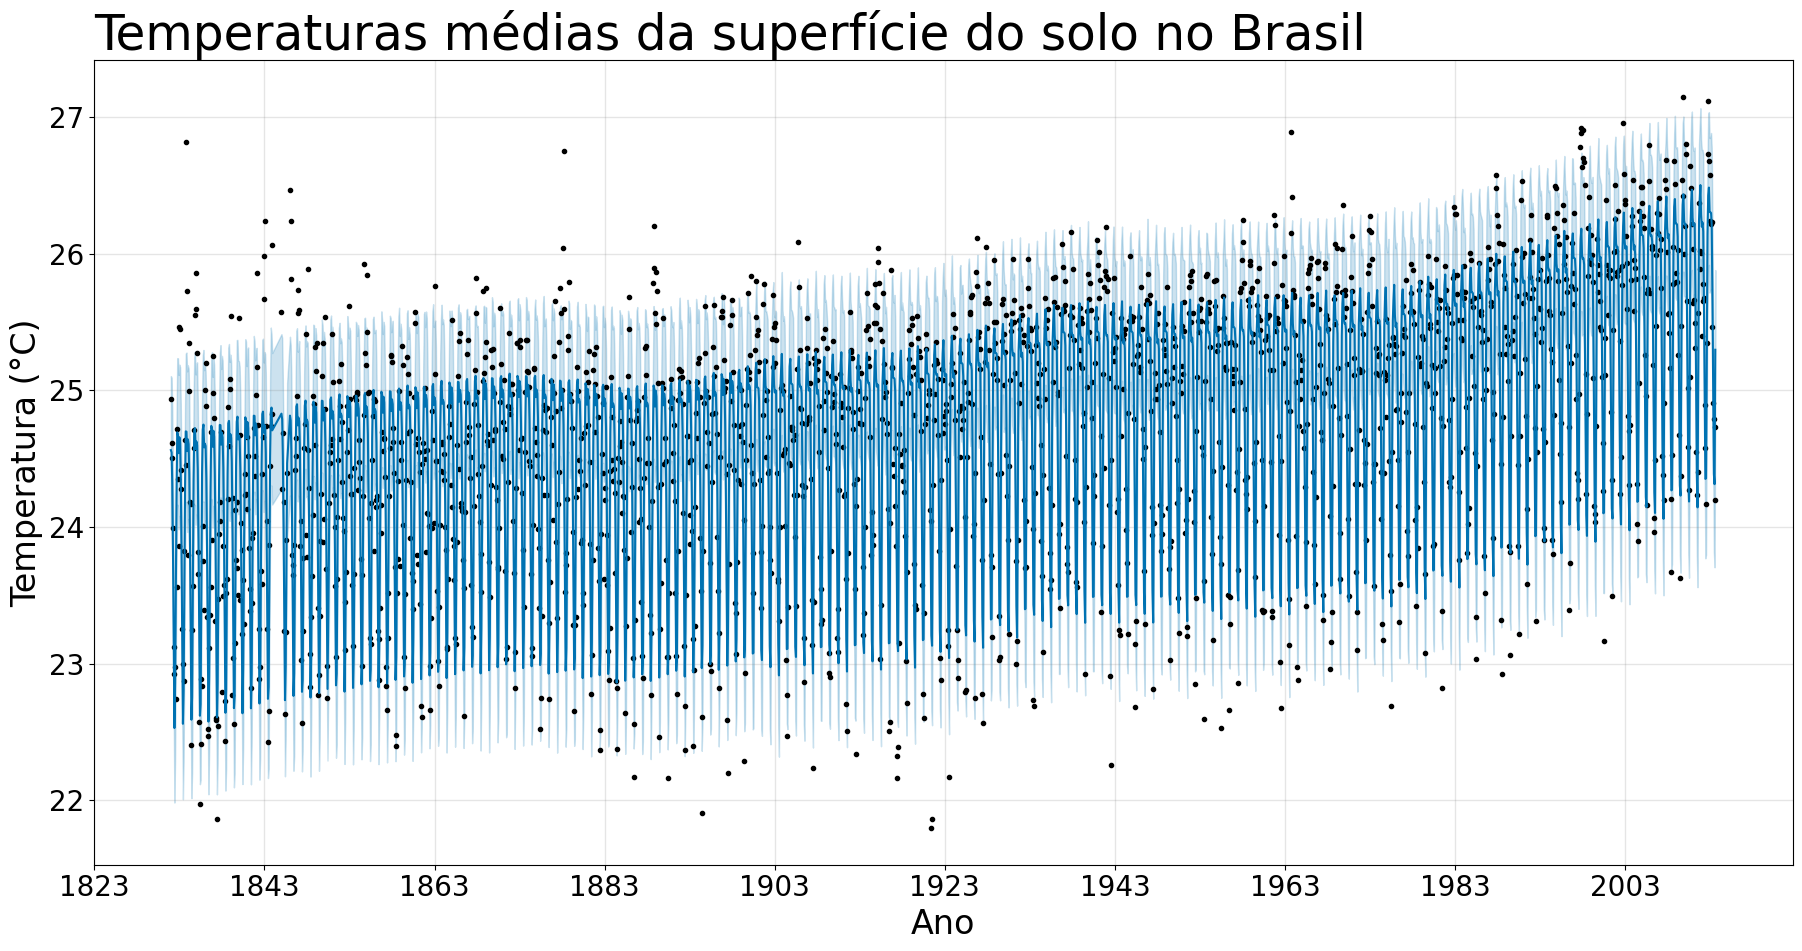

In [237]:
modelo.plot(previsao, figsize=(18, 9))
plt.title('Temperaturas médias da superfície do solo no Brasil', loc='left', fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Ano', fontsize=24)
plt.ylabel('Temperatura (°C)', fontsize=24)
plt.show()


Essa é a previsão. Os pontos representam os valores reais de y (temperatura). A linha sólida escura são os valores de yhat (valor final previsto, combinação de tendencia, termos multiplicativos e termos aditivos).

Como o Prophet é um modelo aditivo, ele gera uma curva complexa que pode ser decomposta em suas partes constituintes.

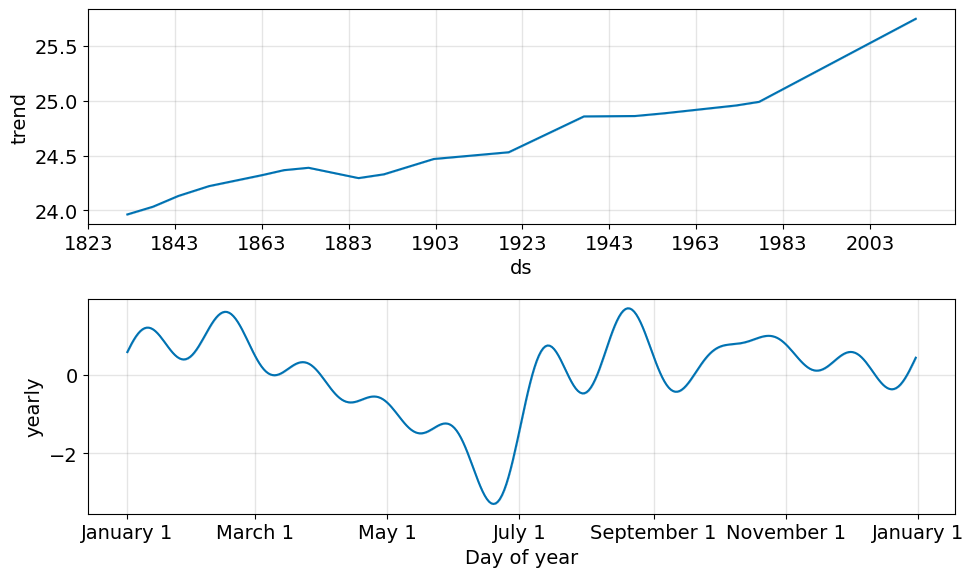

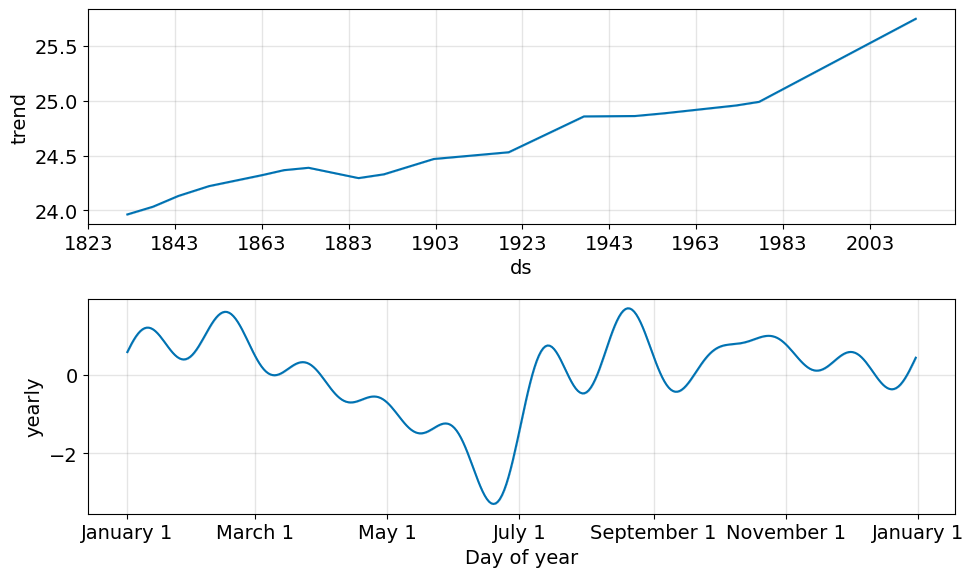

In [238]:
modelo.plot_components(previsao, figsize=(10,6))

Como podemos ver, temos dois componentes, trends e sazonalidade. Podemosver que na tendencia as temperaturas estão aumentando ao longo dos anos. A tendendia aumenta constantemente, mas parece ter uma inclinação acentuada a medida que o tempo avança. No componente anual, as temperaturas diminuem entre maio a julho.

## Adicionando período de previsão

In [239]:
# Usar um período de 10 anos (120 meses) A menor subdivisão dos nossos dados é em meses, por isso a frequencia deve ser M.
modelo = Prophet()
modelo.fit(data)
dataFramefuturo = modelo.make_future_dataframe(periods=120, freq='M')
previsao = modelo.predict(dataFramefuturo)

15:09:07 - cmdstanpy - INFO - Chain [1] start processing
15:09:07 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


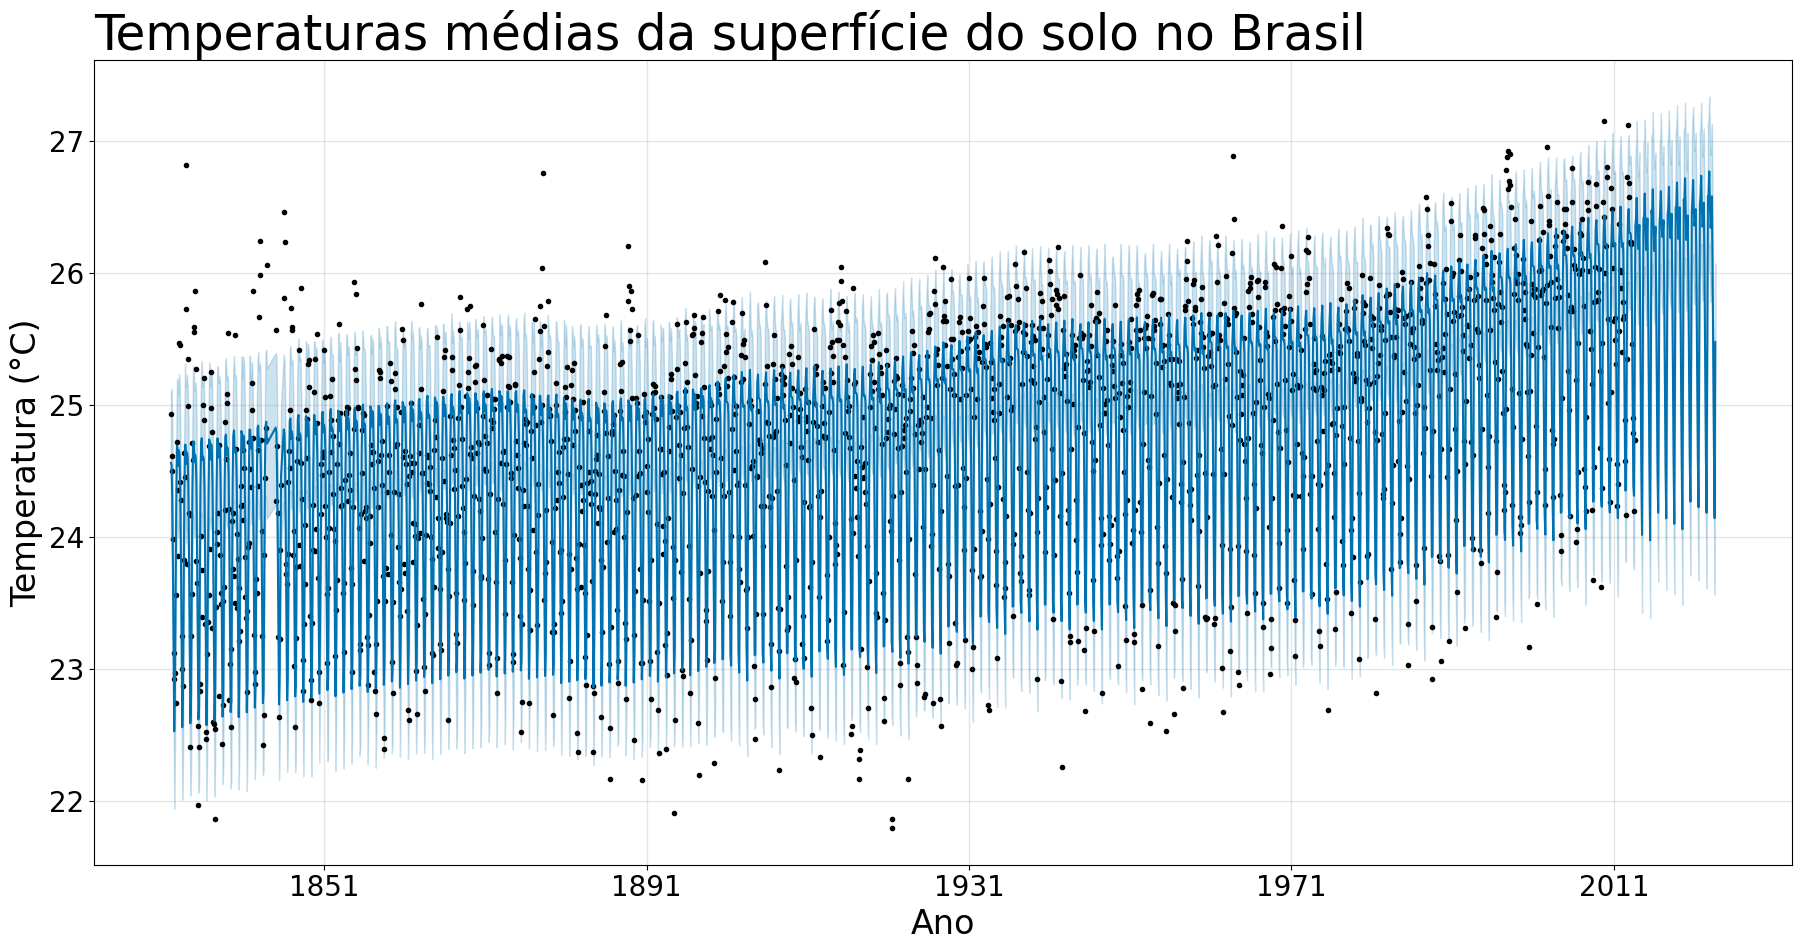

In [240]:
modelo.plot(previsao, figsize=(18, 9))
plt.title('Temperaturas médias da superfície do solo no Brasil', loc='left', fontsize=35)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Ano', fontsize=24)
plt.ylabel('Temperatura (°C)', fontsize=24)
plt.show()

A previsão é esse período no final onde não tem pontos.

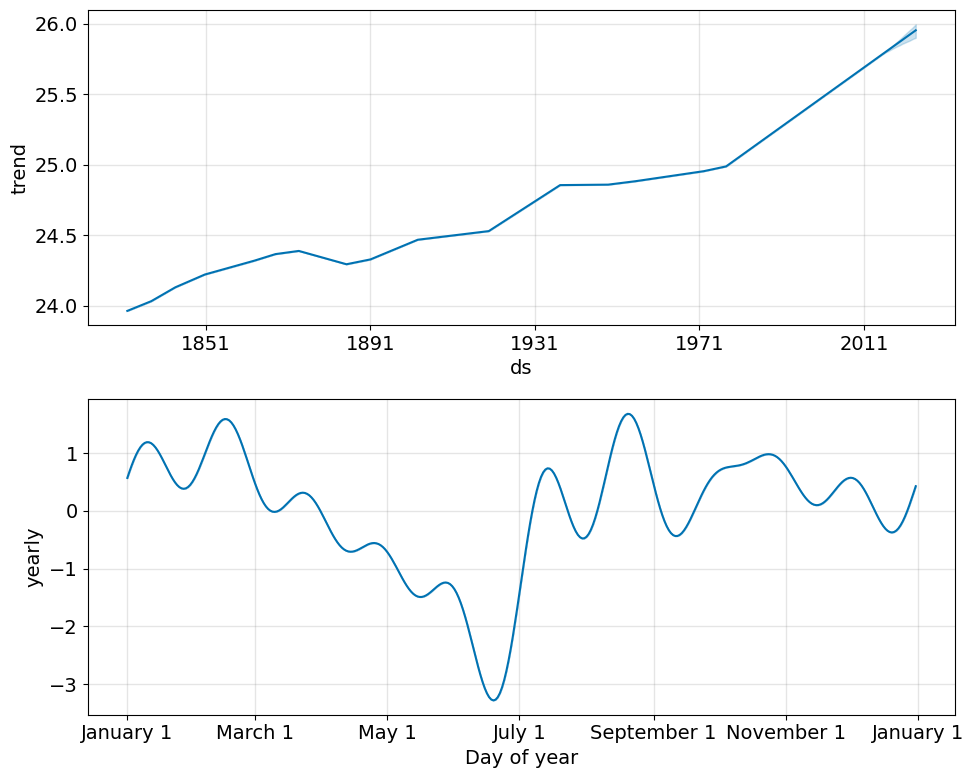

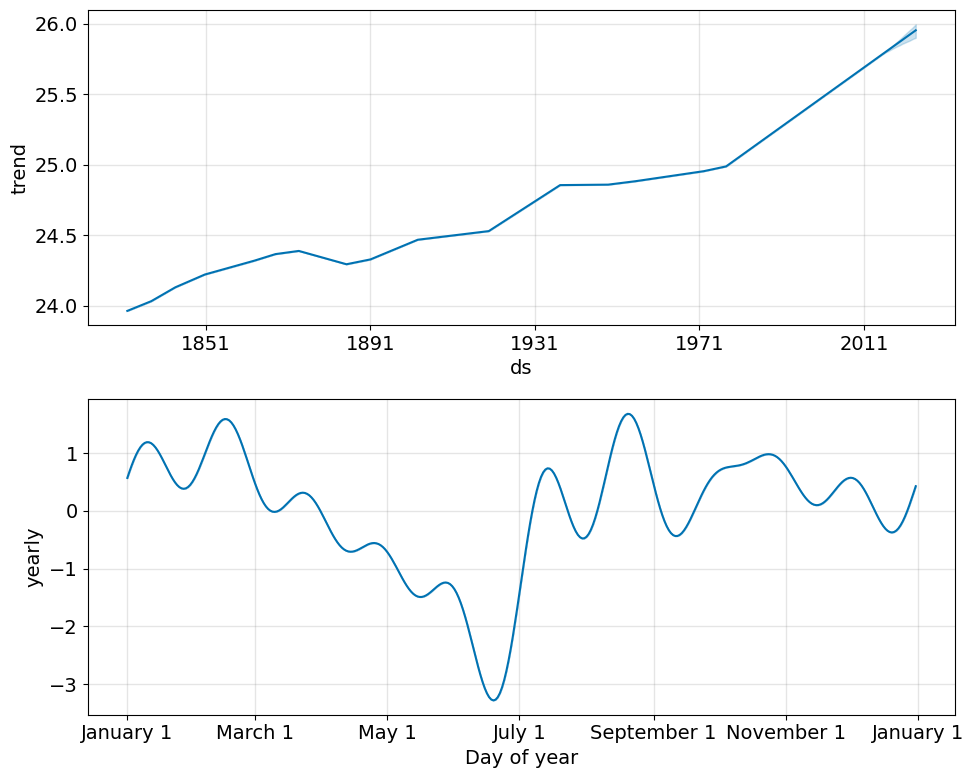

In [241]:
modelo.plot_components(previsao, figsize=(10,8))

Podemos ver na linha de tendencia os intervalos de incerteza nos anos previstos, quanto mais nos afastamos dos dados ajustados, maior essa incerteza.

# Aprofundando as previsões

Agora queremos saber como dados que não foram utilizados pra treinar o modelo se aderem aos valores de yhat calculados. Então vamos separar em treino e teste.

In [242]:
df_train = pd.DataFrame()

In [243]:
# Definindo quantidade de dados para cada um
df_train['ds'] = df_brazil['dt'][:2000]
df_train['y'] = df_brazil['AverageTemperature'][:2000]

In [244]:
df_test = pd.DataFrame()

In [245]:
df_test['ds'] = df_brazil['dt'][2000:]
df_test['y'] = df_brazil['AverageTemperature'][2000:]


In [246]:
model = Prophet()
model.fit(df_train)

dataFramefuturo = model.make_future_dataframe(periods=150, freq='M')
previsao = model.predict(dataFramefuturo)

15:09:08 - cmdstanpy - INFO - Chain [1] start processing
15:09:08 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


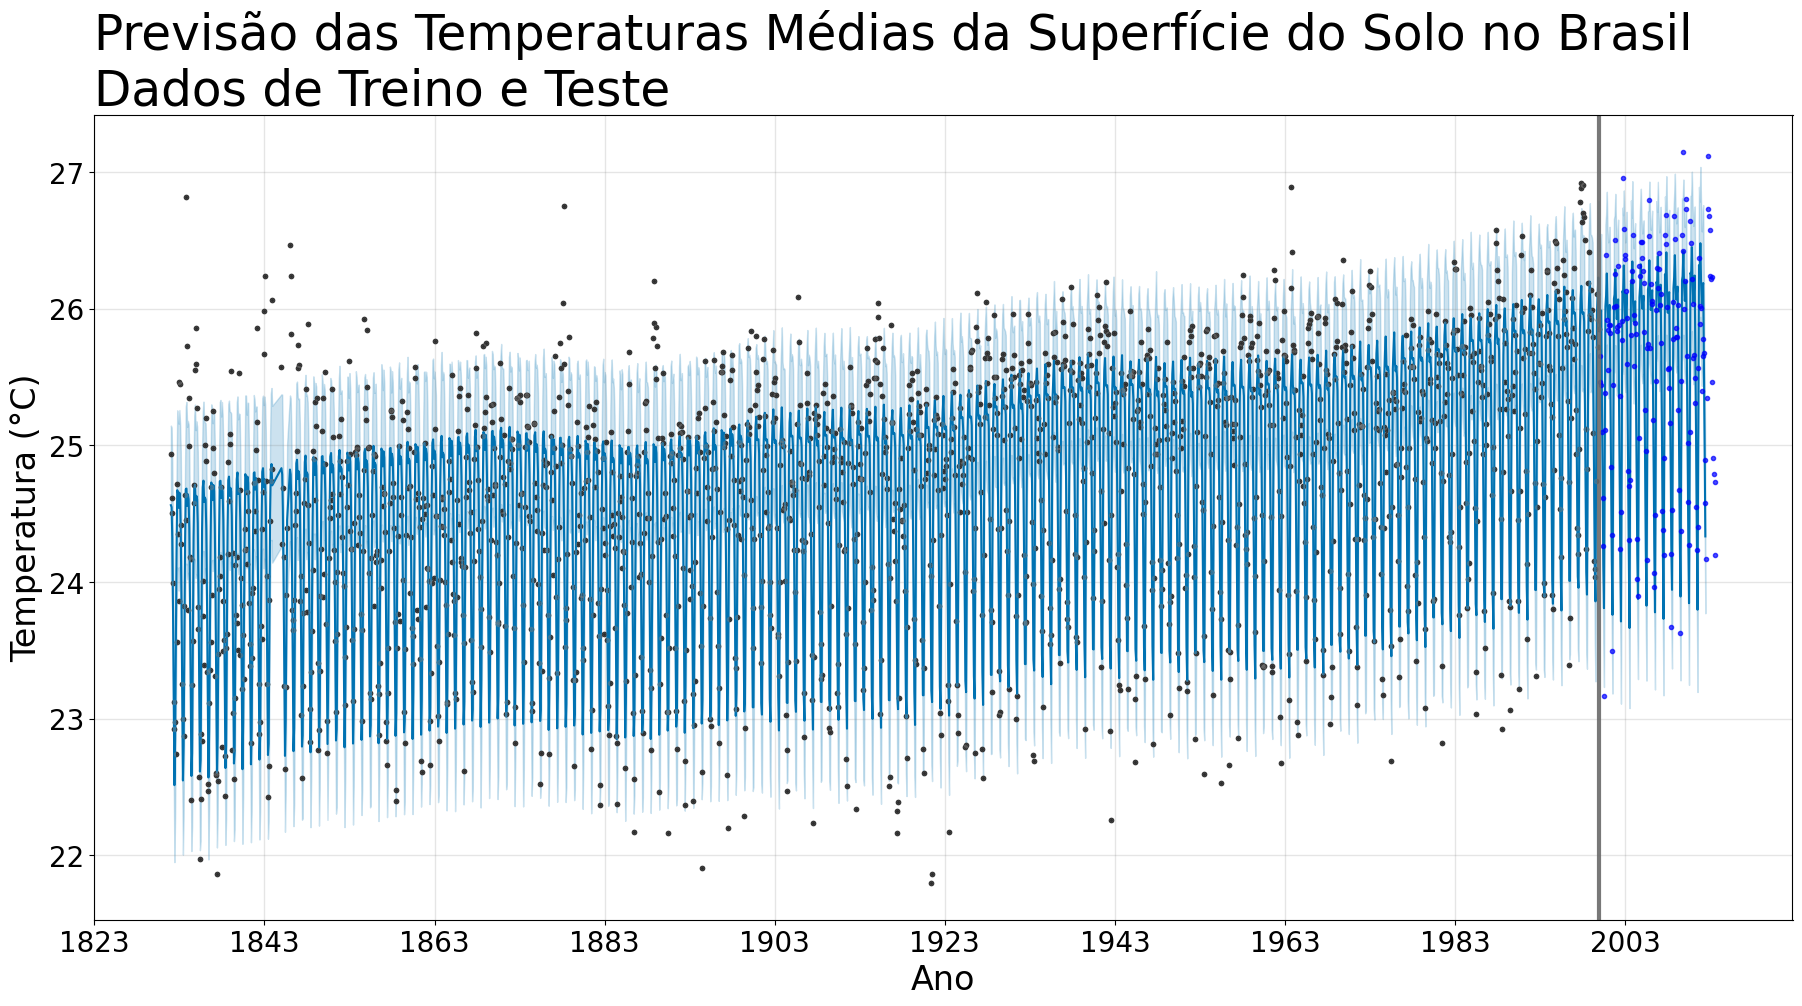

In [247]:
fig = model.plot(previsao, figsize=(18, 9))
ax = fig.axes[0]  # <- pega o axes criado pelo Prophet

ax.set_title(
    'Previsão das Temperaturas Médias da Superfície do Solo no Brasil\nDados de Treino e Teste',
    loc='left', fontsize=35
)

ax.plot(df_train['ds'], df_train['y'], '.', color='grey', alpha=0.35)
ax.plot(df_test['ds'], df_test['y'], '.', color='blue', alpha=0.7)

ax.axvline(x=df_train['ds'].max(), color='dimgray', lw=3, alpha=0.9)

ax.tick_params(axis='both', labelsize=20)
ax.set_xlabel('Ano', fontsize=24)
ax.set_ylabel('Temperatura (°C)', fontsize=24)

plt.show()


Podemos ver que de modo geral os dados de teste estao bem aderidos a nossa previsao, pois temos poucos pontos fora.

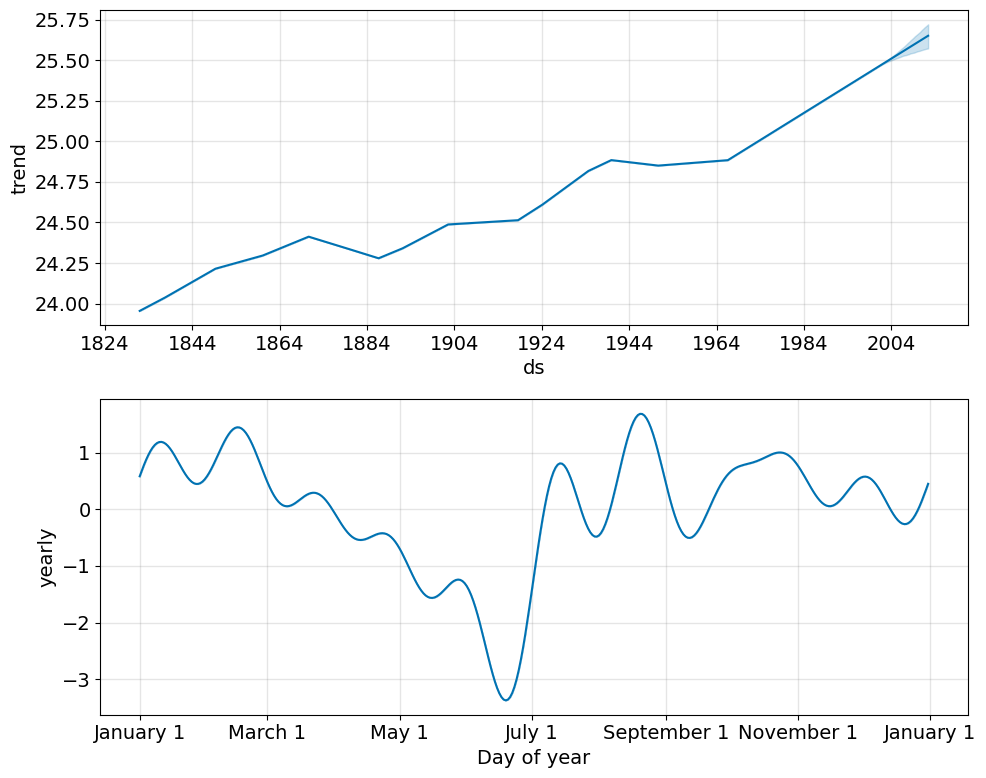

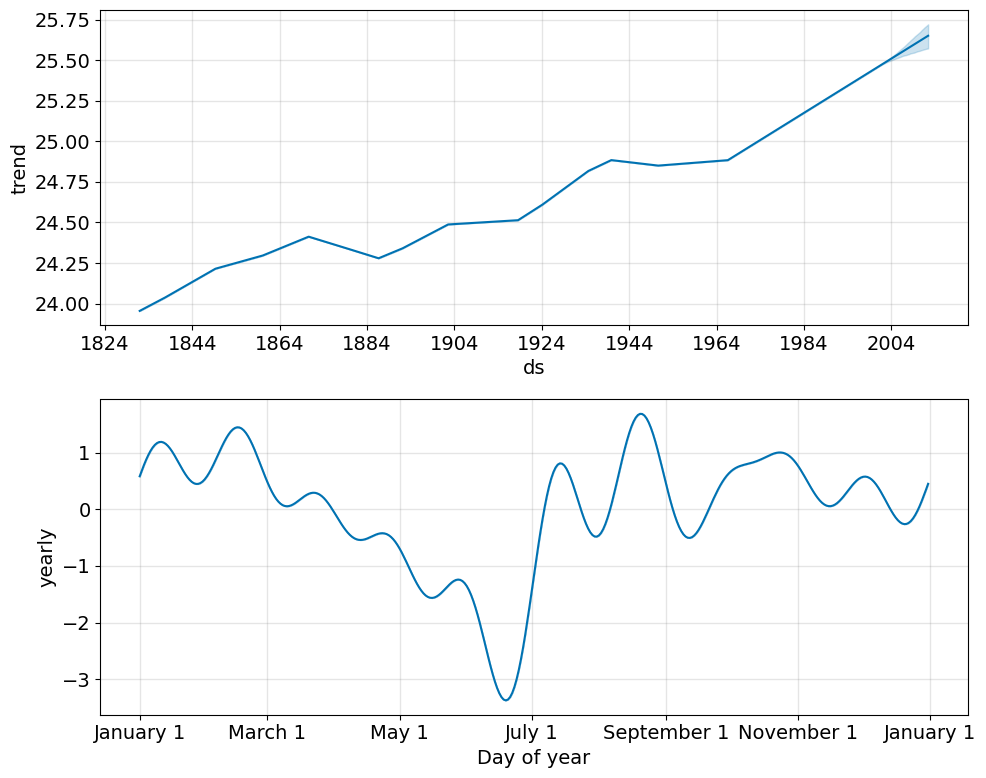

In [248]:
model.plot_components(previsao, figsize=(10,8))

## Previsão de crescimento

In [249]:
#covid = pd.read_csv("/Users/leticiapires/Desktop/dev/ClimateChange/covid_sp.csv")
#covid.head()

Colunas importantes e que serão usadas:
- `date`
- `last_available_confirmed`: número de casos acumulados

In [250]:
#covid['date'] = pd.to_datetime(covid['date'], format='%Y-%m-%d')

In [251]:
#fig, ax = plt.subplots(figsize=(14, 6))
#sns.lineplot(x='date', y='last_available_confirmed', data=covid, linewidth=4, color = 'skyblue')
#plt.title('SARS-CoV-2: Casos Acumulados na cidade de São Paulo', fontsize=25)
#plt.ylabel('Numero de casos', fontsize=20)
#plt.xlabel('Data', fontsize=20)
#plt.ticklabel_format(style='plain', axis='y')
#plt.show()

É possível observar que a curva está apresentando um formato parecido ao de S. Nós tivemos fases de crescimento exponencial ao longo da pandemia. Porém, após uma série de medidas e inicio da vacinação é notável que teve tendência de estabilização.

In [252]:
#df_covid = pd.DataFrame()
#df_covid['ds'] = covid['date']
#df_covid['y'] = covid['last_available_confirmed']



In [253]:
# Devemos especificar a capacidade de carga criando uma coluna chamada cap. Aqui assumimos 1000000, pois os valores mais altos dos dados estão próximos a esse valor.

#df_covid["cap"] = 1000000

In [254]:
#df_covid.head()

Por fim, vamos rodar o modelo utilizando o crescimento logistico, passando um argumento adicional.

In [255]:
#model = Prophet(growth='logistic')
#model.fit(df_covid)

#dataFramefuturo = model.make_future_dataframe(periods=30)
#dataFramefuturo['cap'] = 1000000
#previsao = model.predict(dataFramefuturo)



In [256]:
#model.plot(previsao, figsize=(18, 9))
#plt.title('Previsão de crescimento de SARS-CoV-2: Casos Acumulados na cidade de São Paulo', loc='left', fontsize=35)
#plt.xticks(fontsize=20)
#plt.yticks(fontsize=20)
#plt.xlabel('Ano', fontsize=24)
#plt.ylabel('Numero de casos', fontsize=24)
#plt.ticklabel_format(style='plain', axis='y')
#plt.show()

Linha tracejada representa saturação, capacidade de carga. Após a curva em preto (que contem nossos dados), temos a região em cinza prevista bem proxima a capacidade de carga delimitada.

##  Changepoints

Changepoints são pontos de mudança que permitem identificar em quais datas ocorreram possíveis mudanças no comportamento da nossa série temporal.

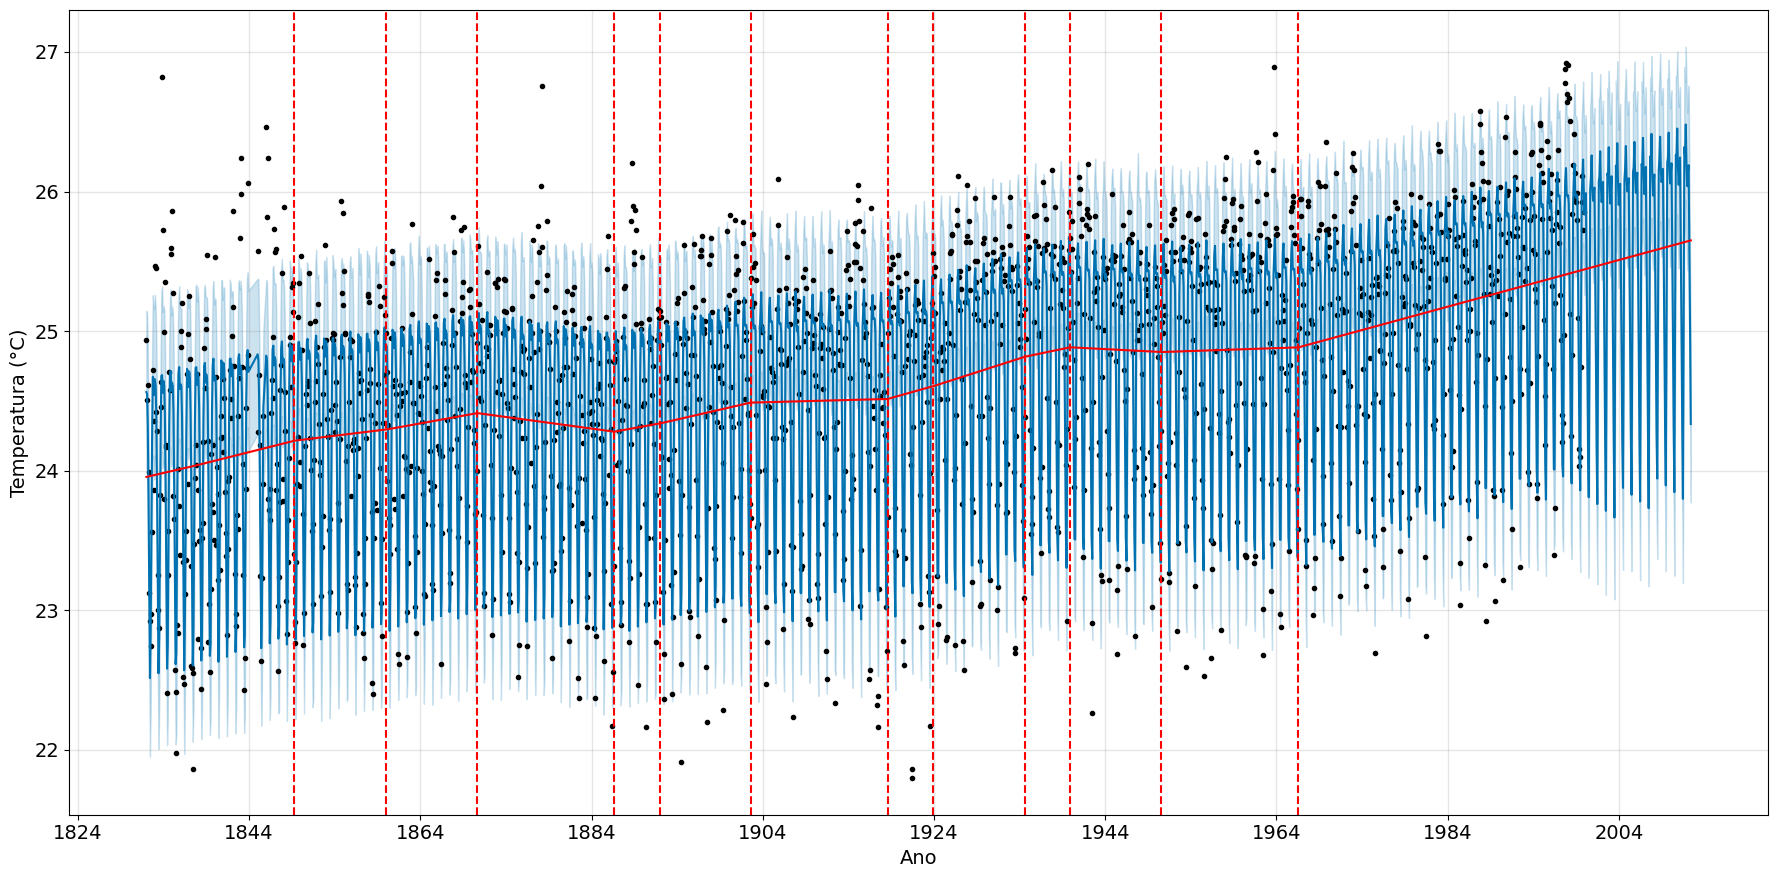

In [257]:
fig = model.plot(previsao, figsize = (18, 9))
a = add_changepoints_to_plot(fig.gca(), model, previsao)
plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.show()


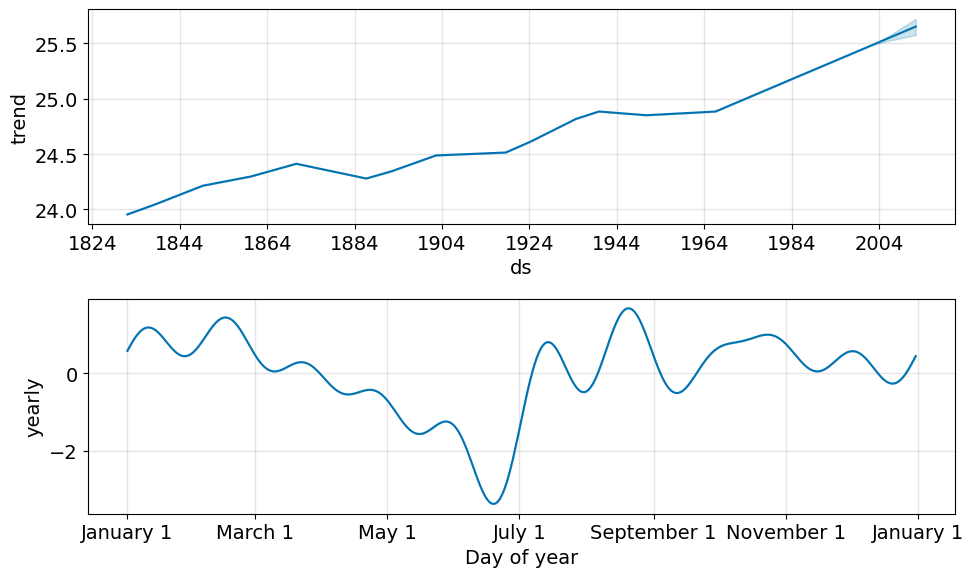

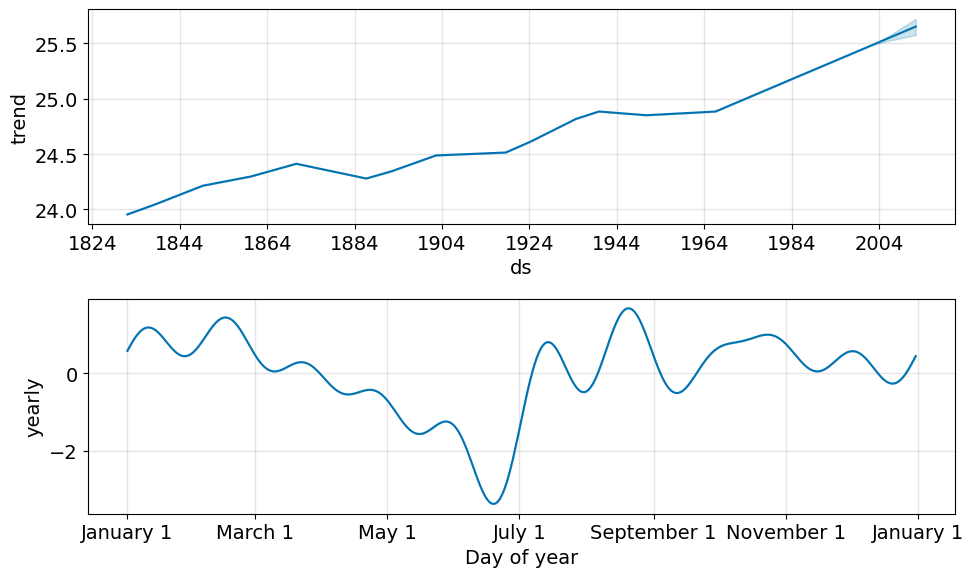

In [258]:
model.plot_components(previsao, figsize=(10,6))

## Alterando o número de Changepoints

In [259]:
data.head()

ds       y
77110 1832-01-01  24.935
77111 1832-02-01  24.505
77112 1832-03-01  24.617
77113 1832-04-01  23.990
77114 1832-05-01  23.124

In [269]:
model = Prophet(n_changepoints=5)
model.fit(data)
dataFramefuturo = model.make_future_dataframe(periods=15, freq='M')
previsao = model.predict(dataFramefuturo)

15:15:11 - cmdstanpy - INFO - Chain [1] start processing
15:15:11 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


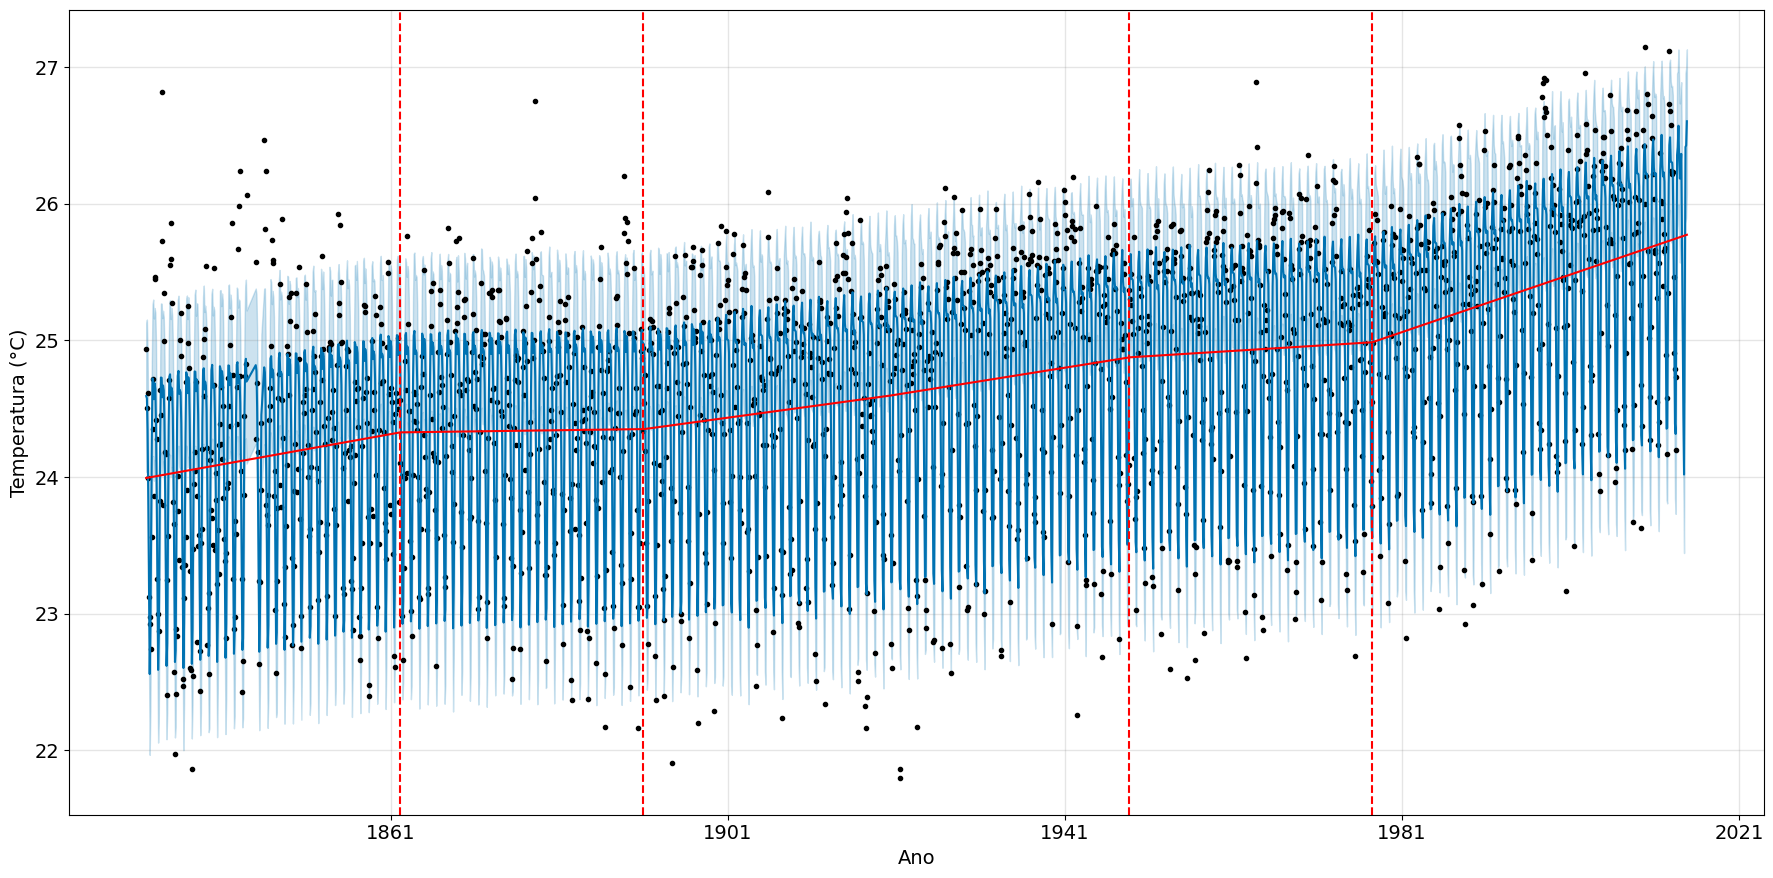

In [270]:
fig = model.plot(previsao, figsize=(18, 9))
a = add_changepoints_to_plot(fig.gca(), model, previsao)
plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.show()

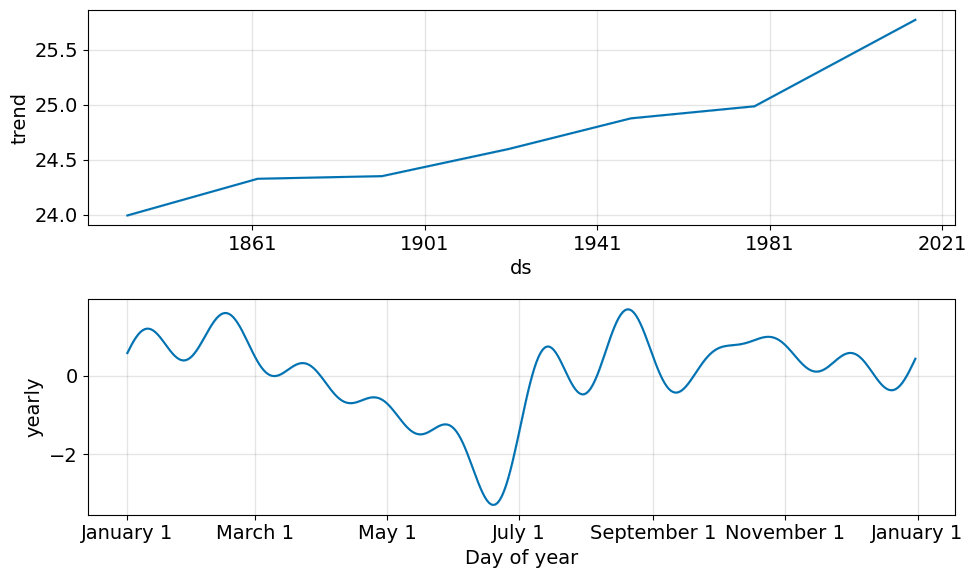

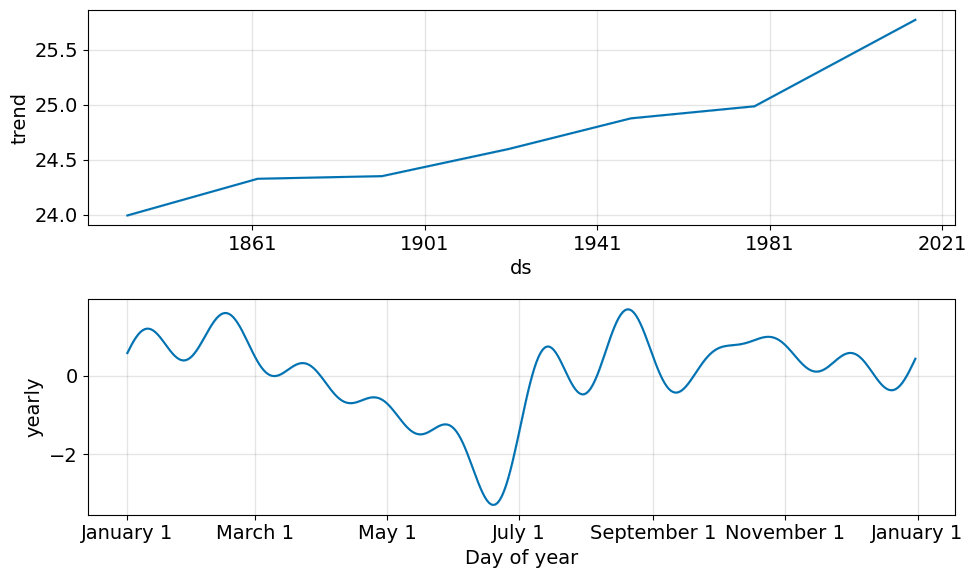

In [271]:
model.plot_components(previsao, figsize=(10,6))

Não ter tantos changepoints é algo que diminui a possibilidade de overfitting.

In [272]:
# changepoint_range
# alterar onde eles serão adicionados, o padrão é 0.80
# isso signfica que o modelo não se ajustará a nenhuma tendencia nos ultimos 20% da série ára manter tendencia geral da serie.

model = Prophet(n_changepoints=5, changepoint_range=0.90)
model.fit(data)
dataFramefuturo = model.make_future_dataframe(periods=15, freq='M')
previsao = model.predict(dataFramefuturo)


15:15:24 - cmdstanpy - INFO - Chain [1] start processing
15:15:24 - cmdstanpy - INFO - Chain [1] done processing
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/prophet/forecaster.py:1875: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


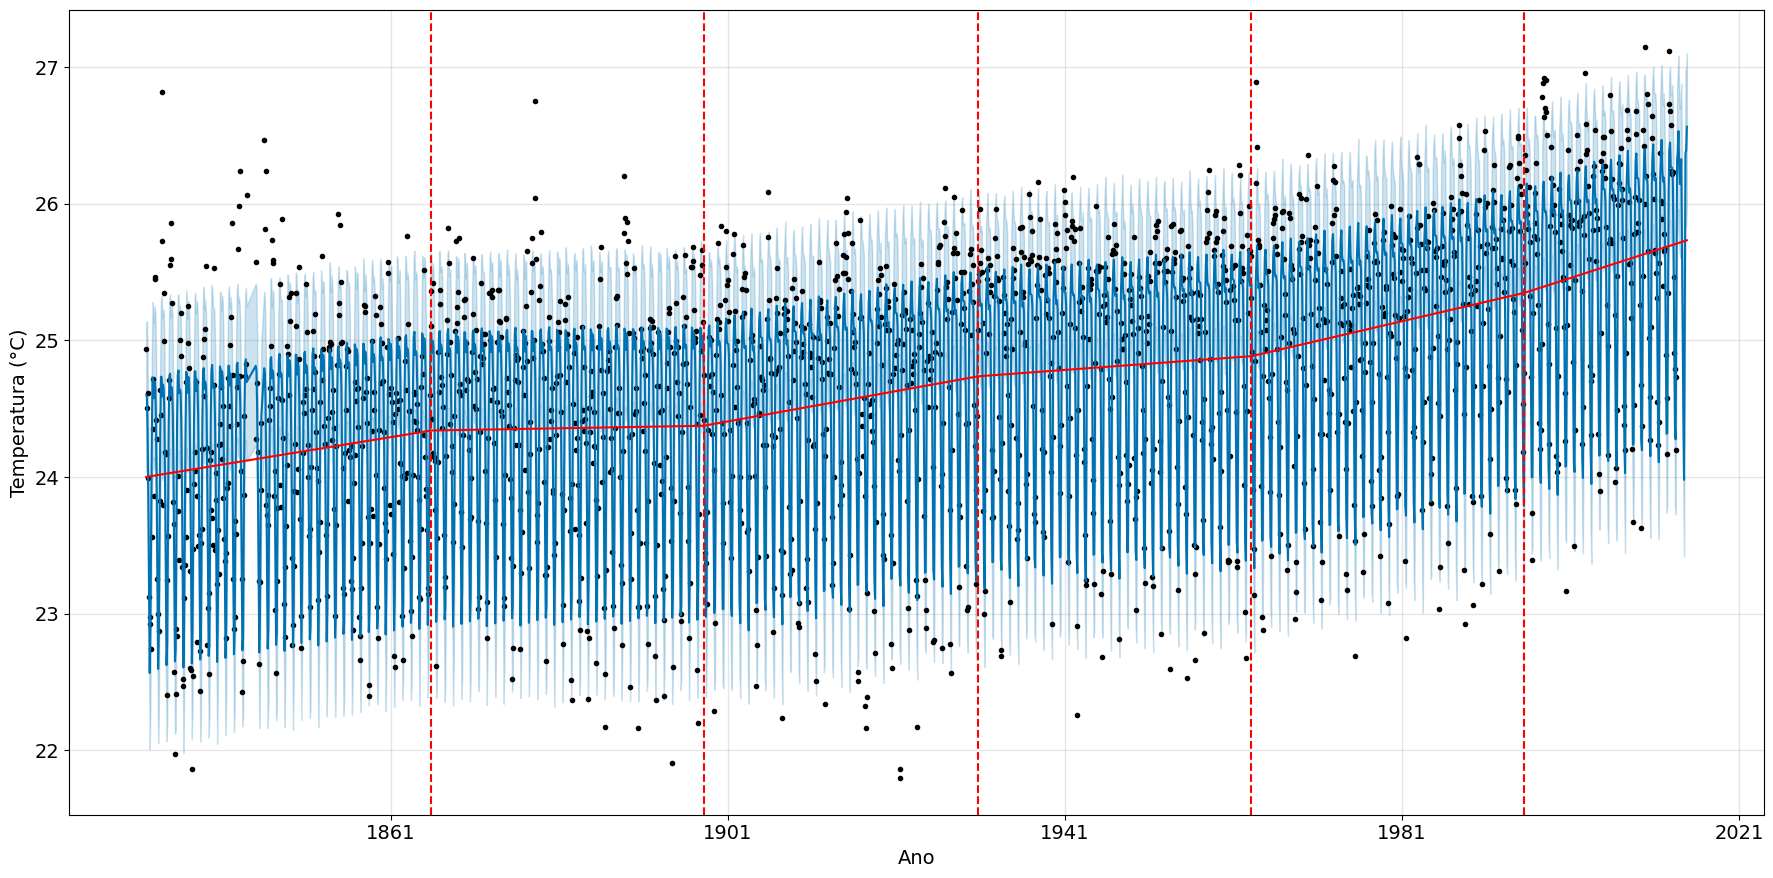

In [273]:
fig = model.plot(previsao, figsize=(18, 9))
a = add_changepoints_to_plot(fig.gca(), model, previsao)
plt.xlabel('Ano')
plt.ylabel('Temperatura (°C)')
plt.show()


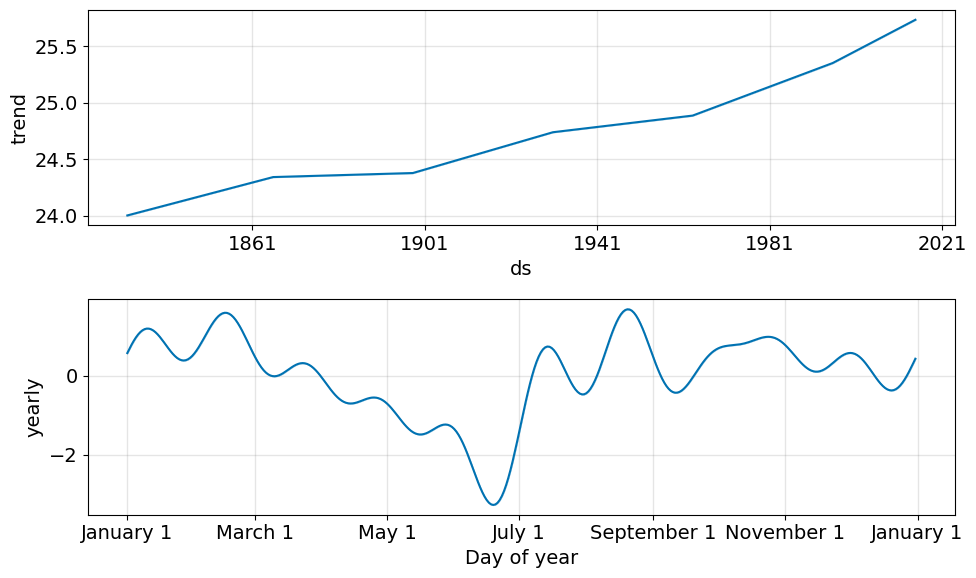

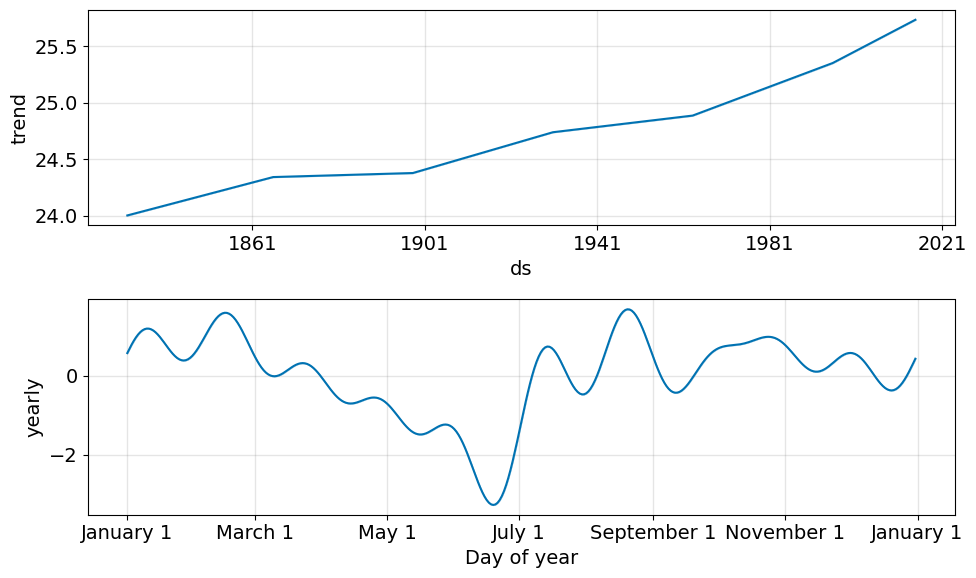

In [265]:
model.plot_components(previsao, figsize=(10,6))
